In [1]:
!pip install pytorch-lightning torchvision pillow tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os

path = "/content/drive/MyDrive/anime_dataset/images"
print("Exists:", os.path.exists(path))
print("Total images:", len(os.listdir(path)))
print("First 5:", os.listdir(path)[:5])


Exists: True
Total images: 18368
First 5: ['2560_2002.jpg', '25664_2009.jpg', '25730_2009.jpg', '25707_2009.jpg', '25692_2009.jpg']


In [4]:
import os, glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [5]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir, max_images=10000, transform=None):
        self.image_paths = sorted(
            glob.glob(os.path.join(root_dir, "*.jpg"))
        )[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

dataset = AnimeDataset(
    "/content/drive/MyDrive/anime_dataset/images",
    transform=transform
)

print("Images loaded:", len(dataset))


Images loaded: 10000


In [7]:
data_loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

print("DataLoader ready")


DataLoader ready


In [8]:
class Generator(nn.Module):
    def __init__(self, nz=100):
        super().__init__()
        self.nz = nz
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), self.nz, 1, 1))


In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [10]:
import pytorch_lightning as pl


In [11]:
class DCGAN(pl.LightningModule):
    def __init__(self, nz=100):
        super().__init__()
        self.nz = nz
        self.generator = Generator(nz)
        self.discriminator = Discriminator()
        self.loss = nn.BCELoss()
        self.automatic_optimization = False

    def training_step(self, batch, batch_idx):
        real = batch
        bs = real.size(0)
        opt_g, opt_d = self.optimizers()

        valid = torch.ones(bs, device=self.device)
        fake = torch.zeros(bs, device=self.device)

        z = torch.randn(bs, self.nz, device=self.device)
        fake_imgs = self.generator(z).detach()

        d_loss = (self.loss(self.discriminator(real), valid) +
                  self.loss(self.discriminator(fake_imgs), fake)) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        z = torch.randn(bs, self.nz, device=self.device)
        g_loss = self.loss(self.discriminator(self.generator(z)), valid)

        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

    def configure_optimizers(self):
        return [
            torch.optim.Adam(self.generator.parameters(), lr=2e-4),
            torch.optim.Adam(self.discriminator.parameters(), lr=2e-4)
        ]


In [12]:
model = DCGAN()

trainer = pl.Trainer(
    max_epochs=5,   # keep small
    accelerator="cpu",  # GPU optional
    devices=1
)

trainer.fit(model, data_loader)


Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79/79 0:10:17 • 0:00:00 0.17it/s v_num: 0.000

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


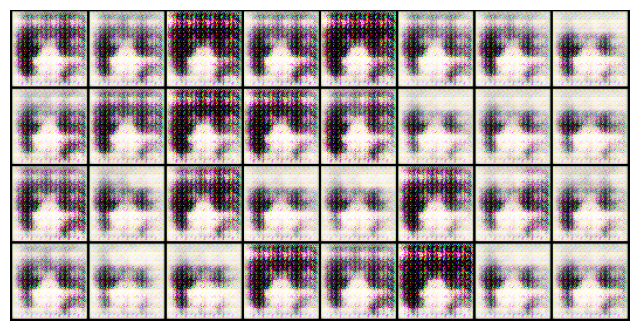

In [13]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

z = torch.randn(32, 100)
with torch.no_grad():
    imgs = model.generator(z)

imgs = (imgs + 1) / 2
grid = vutils.make_grid(imgs, nrow=8)

plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()


In [14]:
vutils.save_image(imgs, "generated_anime_sample.png", nrow=8)
print("Saved generated_anime_sample.png")


Saved generated_anime_sample.png


In [15]:
trainer = pl.Trainer(
    max_epochs=30,        # increase gradually
    accelerator="gpu",
    devices=1
)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [16]:
!pip install pytorch-lightning torchvision pillow


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os, glob
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils

import pytorch_lightning as pl
import matplotlib.pyplot as plt


In [19]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir, max_images=18000, transform=None):
        self.image_paths = sorted(
            glob.glob(os.path.join(root_dir, "*.jpg"))
        )[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


In [20]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

dataset = AnimeDataset(
    "/content/drive/MyDrive/anime_dataset/images",
    max_images=18000,
    transform=transform
)

print("Total images used:", len(dataset))

data_loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


Total images used: 18000


In [21]:
class Generator(nn.Module):
    def __init__(self, nz=100):
        super().__init__()
        self.nz = nz
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), self.nz, 1, 1))


In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [23]:
class DCGAN(pl.LightningModule):
    def __init__(self, nz=100):
        super().__init__()
        self.nz = nz
        self.generator = Generator(nz)
        self.discriminator = Discriminator()
        self.loss = nn.BCELoss()
        self.automatic_optimization = False

    def training_step(self, batch, batch_idx):
        real = batch
        bs = real.size(0)

        opt_g, opt_d = self.optimizers()

        valid = torch.ones(bs, device=self.device)
        fake = torch.zeros(bs, device=self.device)

        # ---- Train Discriminator ----
        z = torch.randn(bs, self.nz, device=self.device)
        fake_imgs = self.generator(z).detach()

        d_loss = (
            self.loss(self.discriminator(real), valid) +
            self.loss(self.discriminator(fake_imgs), fake)
        ) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        # ---- Train Generator ----
        z = torch.randn(bs, self.nz, device=self.device)
        gen_imgs = self.generator(z)
        g_loss = self.loss(self.discriminator(gen_imgs), valid)

        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        return [opt_g, opt_d]


In [24]:
model = DCGAN()

trainer = pl.Trainer(
    max_epochs=30,          # GOOD quality
    accelerator="gpu",
    devices=1
)

trainer.fit(model, data_loader)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ generator     │ Generator     │  3.6 M │ train │     0 │
│ 1 │ discriminator │ Discriminator │  2.8 M │ train │     0 │
│ 2 │ loss          │ BCELoss       │      0 │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 6.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 32                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


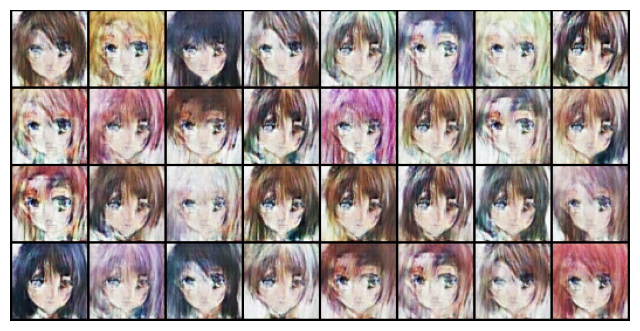

In [25]:
model.generator.eval()

z = torch.randn(32, 100, device=model.device)

with torch.no_grad():
    images = model.generator(z)

images = (images + 1) / 2
grid = vutils.make_grid(images, nrow=8)

plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.show()


In [26]:
vutils.save_image(images, "final_generated_samples.png", nrow=8)
print("Saved final_generated_samples.png")


Saved final_generated_samples.png
